## TODO
    1. Train model after unfreezing layers
    2. Train model with large size dataset - to minimize overfitting
    3. Use model trained on Dogs vs Non-Dogs as a base to train the model
    4. Analyze the results and see which images it's misclassifying

## Imports and definitions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
path = "data/"
sz = 224
bs = 32
arch = resnext50

## Data Download

In [4]:
!rm -r {path}tmp

In [32]:
!rm -r {path}*

In [33]:
!kg download

downloading https://www.kaggle.com/c/dog-breed-identification/download/labels.csv.zip

labels.csv.zip 100% |###############################| Time: 0:00:00 663.0 KiB/s

downloading https://www.kaggle.com/c/dog-breed-identification/download/sample_submission.csv.zip

sample_submission.csv.zip 100% |####################| Time: 0:00:00 954.6 KiB/s

downloading https://www.kaggle.com/c/dog-breed-identification/download/test.zip

test.zip 100% |#####################################| Time: 0:00:09  38.3 MiB/s

downloading https://www.kaggle.com/c/dog-breed-identification/download/train.zip

train.zip 100% |####################################| Time: 0:00:09  35.2 MiB/s



In [34]:
!mv *.zip {path}

In [35]:
files = !ls {path} | grep zip

In [36]:
for file in files:
    !unzip -qq {path}{file} -d {path}
    !rm {path}{file}

In [37]:
!mkdir -p {path}weights
!mkdir -p {path}results
!mkdir -p {path}models

## Validation data split

    1. F strings are ruby string interpolation equivalent in python
    2. Suffix .jpg in from csv removes the suffix from files in the train folder
    3. Low bs => low gpu memory usage

In [7]:
label_csv = f'{path}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, val_pct=0.15)

In [6]:
labels = pd.read_csv(label_csv)

In [8]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path, 'train', label_csv, test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data

## Model Training

In [9]:
data = get_data(sz, bs)

In [10]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

### Train with precomputed layers

In [8]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|███████▌  | 207/272 [00:02<00:00, 85.91it/s, loss=9.92]


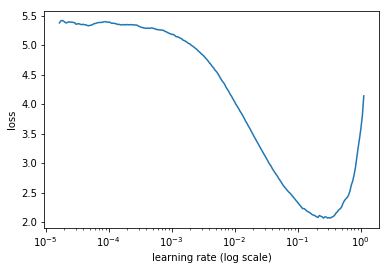

In [9]:
learn.sched.plot()

In [10]:
learn.fit(0.01, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.709729   0.472892   0.900974  
    1      0.422945   0.354313   0.913995                    
    2      0.324058   0.324566   0.914646                    



[0.32456577, 0.9146461921433607]

### Train with data augmentation

In [11]:
learn.precompute = False

In [12]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 86%|████████▋ | 235/272 [00:38<00:06,  6.05it/s, loss=9.11]

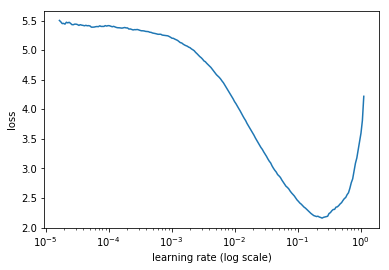

In [13]:
learn.sched.plot()

In [14]:
learn.fit(0.05, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 11%|█         | 29/272 [00:04<00:41,  5.81it/s, loss=3.89]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.609103   0.312914   0.898438  
    1      0.47353    0.318069   0.901042                    
    2      0.450383   0.307584   0.904948                    



[0.30758417, 0.9049479166666666]

In [12]:
submit_predictions(learn)

0.25594                                       


### Learn with dataset change

### Learn with unfreezing

In [15]:
learn.unfreeze()
learn.bn_freeze(True)

In [16]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 36%|███▋      | 99/272 [00:46<01:21,  2.11it/s, loss=1.1]  

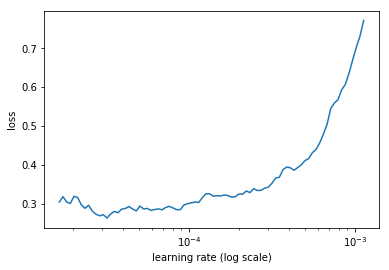

In [17]:
learn.sched.plot()

In [ ]:
learn.fit([1e-4, 1e-3, 1e-2], 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.589071   0.46281    0.848622  
    1      0.833142   0.635104   0.805204                    
    2      0.255159   0.439778   0.855401                    
 92%|█████████▏| 251/272 [01:58<00:09,  2.12it/s, loss=0.86] 

## Analyzing the results

## Submission

In [16]:
def submit_predictions(learner, is_tta=True):
    if is_tta:
        log_probs,_ = learner.TTA(is_test=True)
        probs = np.exp(log_probs)
        probs = np.mean(probs, axis=0)
    else:
        log_probs = learn.predict(is_test=True)
        probs = np.exp(log_probs)
    probs = np.clip(probs, 0.0001, 0.9999)
    test_fnames = data.test_dl.dataset.fnames
    test_ids = list(map(lambda x: re.split('/|\.',x)[1], test_fnames))
    probs_flattened = probs.flatten()
    probs_formatted = np.array(list(map(lambda x: '%0.6f'%x, probs_flattened)))
    probs_formatted = np.reshape(probs_formatted, probs.shape)
    result = list(map(lambda x: [test_ids[x]] + list(probs_formatted[x]), range(len(test_ids))))
    
    result_file = "./data/results/result.csv"
    header = ','.join(['id']+data.classes)
    np.savetxt(result_file, result, delimiter=',', comments='', fmt='%s', header=header)
    !kg submit {result_file}